In [1]:
import numpy as np
import astropy
import ccdproc
import os
import glob
import matplotlib.pyplot as plt
from astropy.nddata import CCDData

In [2]:
#We know read our B and V science images in again to plot a guassian and king fit.
#This is done in order find the centre of the cluster as well as see the best fit 

B = astropy.nddata.CCDData.read('C:/Users/steve/OneDrive - University of Birmingham/LH Observatory Laboratory/Glob Cluter Final Code/GlobClusters/MasterScienceB.fits', unit='adu')

V = astropy.nddata.CCDData.read('C:/Users/steve/OneDrive - University of Birmingham/LH Observatory Laboratory/Glob Cluter Final Code/GlobClusters/MasterScienceVshift.fits', unit='adu')


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [3]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(B, (128, 128), filter_size=(5,5), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

print(bkg.background_median)  
print(bkg.background_rms_median)  

bkg_median = bkg.background_median.value
bkg_rms = bkg.background_rms.value
bkg_rms_median = bkg.background_rms_median.value

192.2201797890617 adu
6.328260030000077 adu


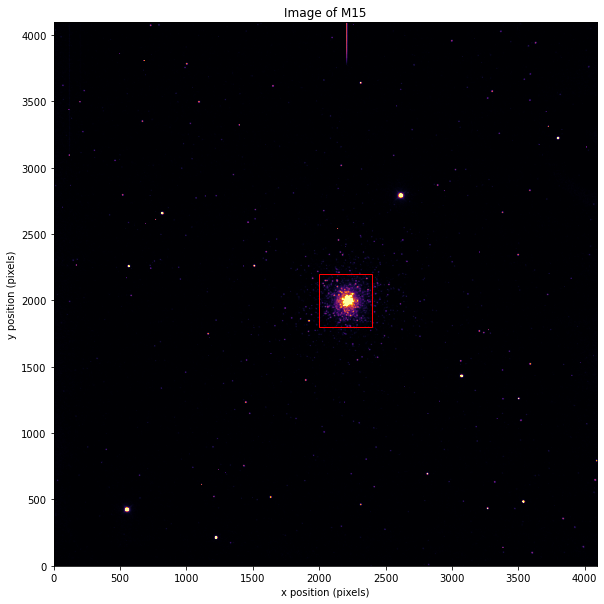

In [4]:
import matplotlib.patches as patches

#Here we outline the section that we are considering our cluster, M15 isn in
#The red box shows the region we are now dealing with from this point onwards


#Show Image
X = np.arange(0, 4096, 1)
Y = np.arange(0, 4096, 1)
#XX, YY = np.meshgrid(X, Y)
Z = np.asarray(B-bkg.background)

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.imshow(B-bkg.background, vmin=0, vmax=200, cmap='inferno', origin='lower')

rect = patches.Rectangle((2000, 1800), 400, 400, linewidth = 1, edgecolor='r', facecolor='none')
ax1.add_patch(rect)
plt.xlabel('x position (pixels)')
plt.ylabel('y position (pixels)')
plt.title('Image of M15')
plt.savefig('Region that we are taking for our cluster')
plt.show()



C:\Users\steve\AppData\Local\Temp/ipykernel_440/3963407411.py:30: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(surf, aspect=5)


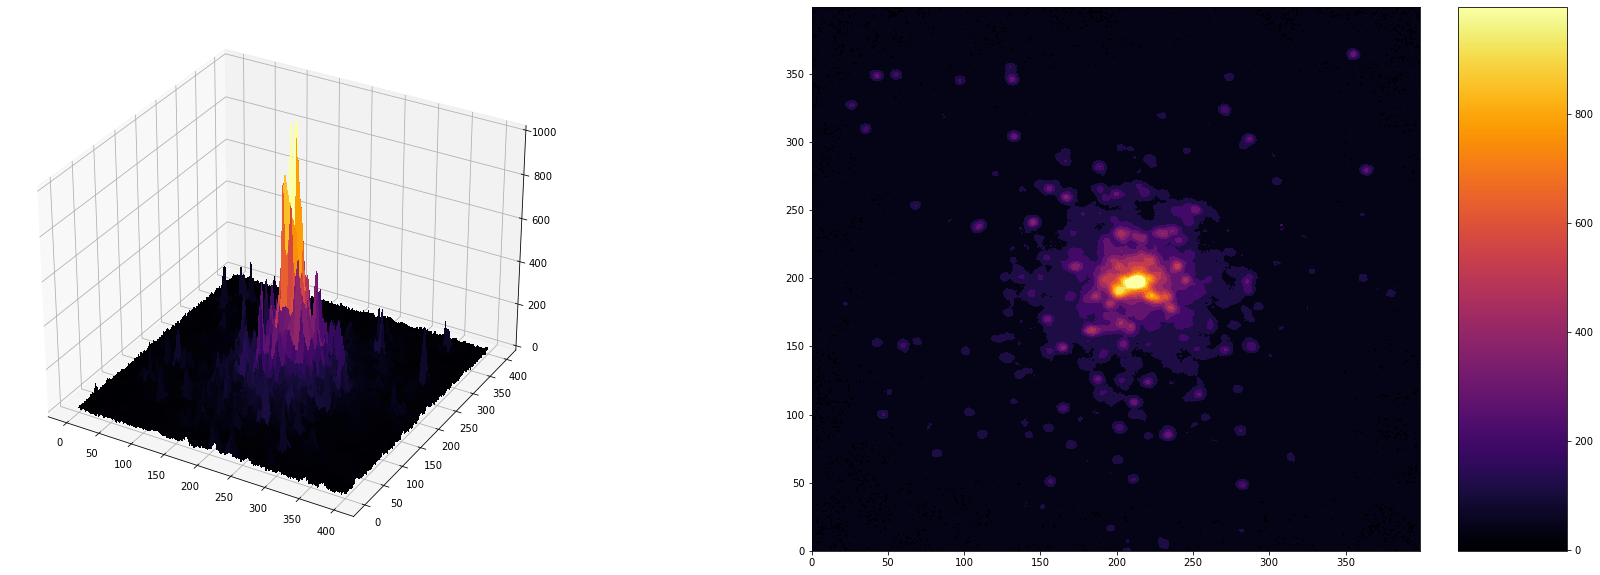

In [5]:
#A 3D surface plot of the data is made to try and get a visual representation of where the centre is and how the distribution of stars is 

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0, 400, 1)
Y = np.arange(0, 400, 1)
XX, YY = np.meshgrid(X, Y)
Z = np.asarray(B[1800:2200, 2000:2400]-bkg.background[1800:2200, 2000:2400])

# Plot the surface.
surf = ax1.plot_surface(XX, YY, Z, cmap='inferno',
                       linewidth=0, antialiased=False)

# # Customize the z axis.
ax1.set_zlim(0, 1000)
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# # Add a color bar which maps values to colors.

ax2 = fig.add_subplot(1, 2, 2)
ax2.contourf(X, Y, Z, vmin=0, vmax=1000, cmap='inferno', levels=50)
plt.colorbar(surf, aspect=5)

plt.show()

In [6]:
#This was an attempted fitting we tried to use but didnt work as Jupyter notebook didnt support the package

# import lmfit
# from lmfit.lineshapes import gaussian2d, lorentzian

# def lorentzian2d(x, y, amplitude=1., centerx=40., centery=60., sigmax=10., sigmay=10.,
#                  rotation=0):
#     """Return a two dimensional lorentzian.

#     The maximum of the peak occurs at ``centerx`` and ``centery``
#     with widths ``sigmax`` and ``sigmay`` in the x and y directions
#     respectively. The peak can be rotated by choosing the value of ``rotation``
#     in radians.
#     """
#     xp = (x - centerx)*np.cos(rotation) - (y - centery)*np.sin(rotation)
#     yp = (x - centerx)*np.sin(rotation) + (y - centery)*np.cos(rotation)
#     R = (xp/sigmax)**2 + (yp/sigmay)**2

#     return 2*amplitude*lorentzian(R)/(np.pi*sigmax*sigmay)


# npoints = 10000
# X = np.arange(0, 100, 1)
# Y = np.arange(0, 100, 1)
# XX, YY = np.meshgrid(X, Y)
# Z = np.asarray(B[1950:2050, 2150:2250])


# fig, ax = plt.subplots()
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# art = ax.pcolor(X, Y, Z, shading='auto')
# plt.colorbar(art, ax=ax, label='z')
# plt.show()

# model = lmfit.Model(lorentzian2d, independent_vars=['x', 'y'])
# params = model.make_params(amplitude=10, centerx=x[np.argmax(z)],
#                            centery=y[np.argmax(z)])
# params['rotation'].set(value=.1, min=0, max=np.pi/2)
# params['sigmax'].set(value=1, min=0)
# params['sigmay'].set(value=2, min=0)

# result = model.fit(z, x=x, y=y, params=params, weights=1/error)
# lmfit.report_fit(result)

(160000,)


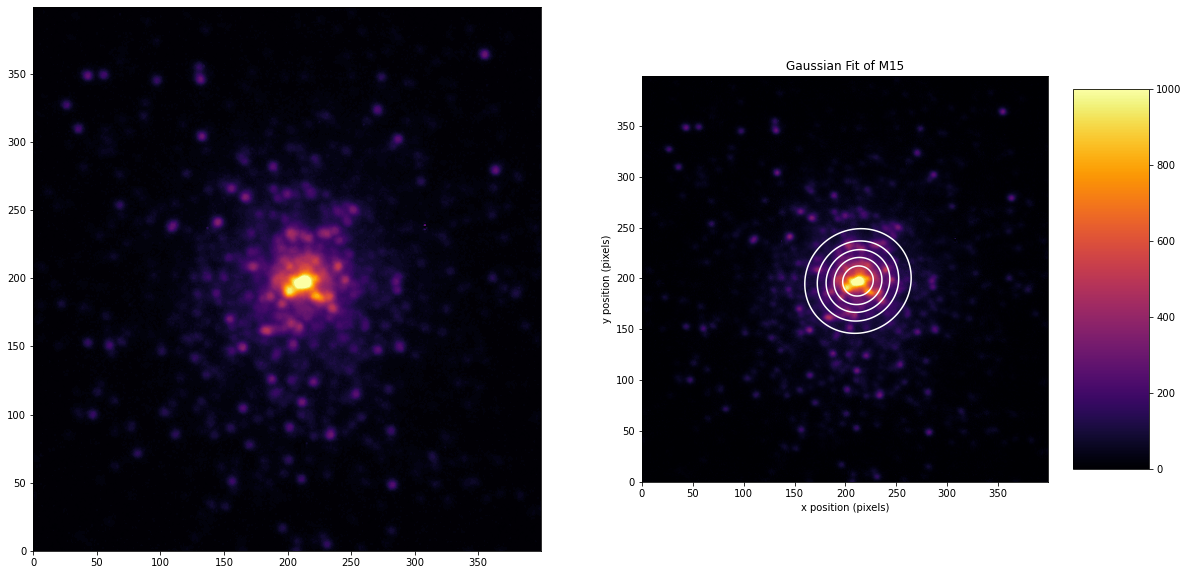

In [7]:
#Here we use a 2D gaussian to fit our data and from this we see quite an accurate centre positioning

import scipy.optimize as opt
import numpy as np

def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y)=xdata_tuple
    xo = float(xo)
    yo = float(yo)   
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    #print(g.ravel().shape)
    return g.ravel()

# Create x and y indices
x = np.arange(0, 400, 1)
y = np.arange(0, 400, 1)
x1, y1 = np.meshgrid(x, y)
# print(x1.shape)
# print(y1.shape)
Z1 = np.asarray(B[1800:2200, 2000:2400]-bkg.background[1800:2200, 2000:2400])
Z = Z1.ravel()
# print(x.shape)
# print(y.shape)
# print(Z.shape)
# print(Z1.shape)

# plot twoD_Gaussian data generated above
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
contour = ax1.contourf(x1, y1, Z1, vmin=0, vmax=1000, cmap='inferno', levels=300)

# add some noise to the data and try to fit the data generated beforehand
initial_guess = (10,200,200,20,40,0,10)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x1, y1), Z, p0=initial_guess)

data_fitted = twoD_Gaussian((x1, y1), *popt)
print(data_fitted.shape)
ax2 = fig.add_subplot(1, 2, 2)
img = ax2.imshow(Z.reshape(400,400), cmap='inferno', origin='lower', vmin=0, vmax=1000,
      extent=(x.min(), x.max(), y.min(), y.max()))
ax2.contour(x1, y1, data_fitted.reshape(400,400), 6, vmin=0, vmax=1000, colors='w')
plt.colorbar(img, aspect=5)

plt.xlabel('x position (pixels)')
plt.ylabel('y position (pixels)')
plt.title('Gaussian Fit of M15')
plt.savefig('Gaussian Fit of M15')
plt.show()

In [8]:
#The parameters of the 2D gaussian are printed here which outline the centre coordinate and other important properties
print(popt)

[564.53632939 212.30015356 197.54013676  27.07986805  25.47163293
   2.49054595  19.42164253]


(160000,)


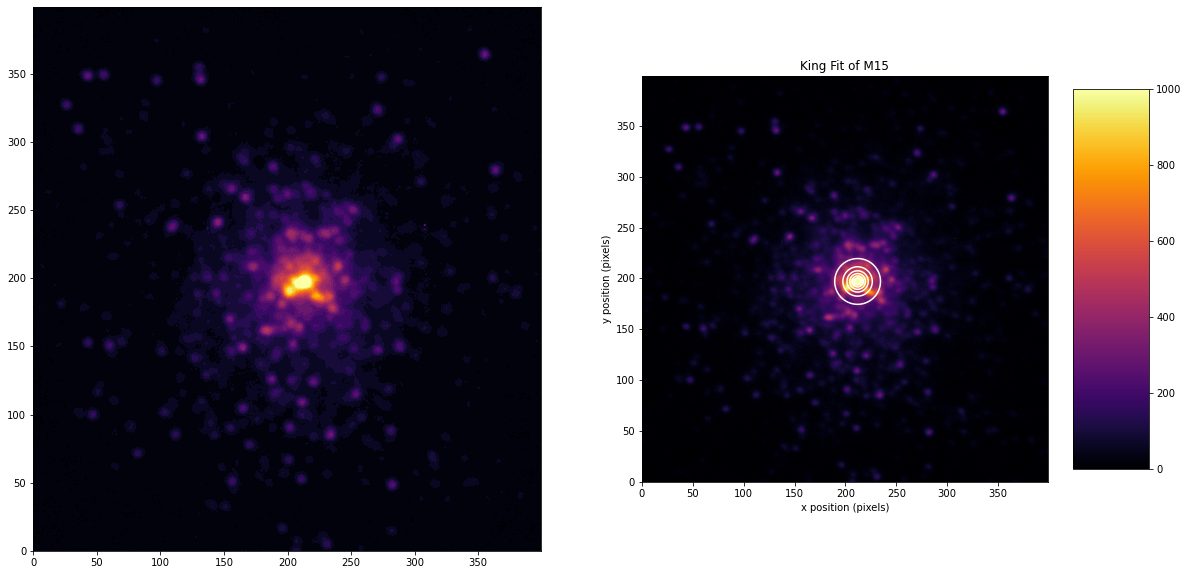

[2.11926492e+02 1.97100517e+02 9.44414806e+00 5.75369956e+08
 2.00000000e+03]
[[ 4.29456631e-04  1.38976732e-12  1.17482089e-08  7.72553213e-21
  -1.64518268e-06]
 [ 1.38976733e-12  4.29456507e-04 -2.31660028e-09  3.21676622e-20
   3.35867268e-07]
 [ 1.17482089e-08 -2.31660028e-09  4.31822740e-04  4.65351190e-16
  -9.12800142e-02]
 [ 7.72553213e-21  3.21676622e-20  4.65351190e-16  6.68318520e-28
  -1.31124565e-13]
 [-1.64518268e-06  3.35867268e-07 -9.12800142e-02 -1.31124565e-13
   2.57267367e+01]]


In [9]:
#We decided that there must be a better fit than the Gaussian and so we read up on the King fit
#The white circles produced show that the cenre coordinate is much more precise and there implying this is a better fit

import scipy.optimize as opt
import numpy as np

def King(xdata_tuple, x0, y0, r_c, r_t, central_brightness):
    (x,  y) = xdata_tuple
    r = ((x - x0)**2 + (y - y0)**2)**(1/2)
    f = central_brightness*((1 + (r**2/r_c**2))**(-(1/2)) - (1 + (r_t**2/r_c**2))**(-(1/2)))**2
    #print(r)
    #print(f.ravel().shape)
    return f.ravel()


# Create x and y indices

x = np.arange(0, 400, 1)
y = np.arange(0, 400, 1)
x1, y1 = np.meshgrid(x, y)
# print(x1.shape)
# print(y1.shape)
Z1 = np.asarray(B[1800:2200, 2000:2400]-bkg.background[1800:2200, 2000:2400])
Z = Z1.ravel()
# print(x.shape)
# print(y.shape)
# print(Z.shape)
# print(Z1.shape)
# plot twoD_Gaussian data generated above
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
contour = ax1.contourf(x1, y1, Z1, vmin=0, vmax=1000, cmap='inferno', levels=100)

# add some noise to the data and try to fit the data generated beforehand
initial_guess = (200, 200, 5, 150, 2000)
bounds = ([180, 180, 1, 1, 2000], [220, 220, np.inf, np.inf, 3000])

popt, pcov = opt.curve_fit(King, (x1, y1), Z, p0=initial_guess, bounds = bounds)

Kingfit = King((x1, y1), *popt)
print(Kingfit.shape)
ax2 = fig.add_subplot(1, 2, 2)
img = ax2.imshow(Z.reshape(400,400), cmap='inferno', origin='lower', vmin=0, vmax=1000,
      extent=(x.min(), x.max(), y.min(), y.max()))
ax2.contour(x1, y1, Kingfit.reshape(400,400), 6, colors='w')
plt.colorbar(img, aspect=5)

plt.xlabel('x position (pixels)')
plt.ylabel('y position (pixels)')
plt.title('King Fit of M15')
plt.savefig('King Fit of M15')
plt.show()
print(popt)
print(pcov)

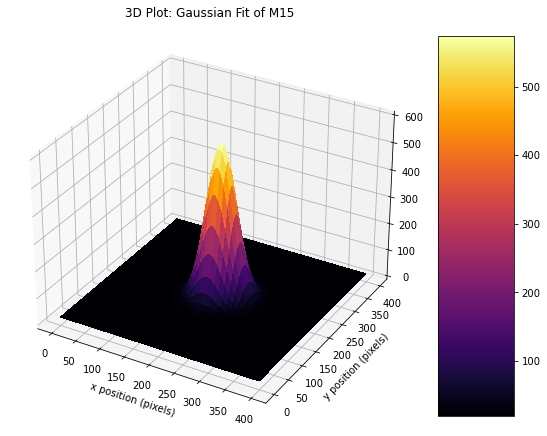

In [10]:
#We plot 3D surface plots of the Gaussian and king to see how positiona varies 

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')

# Make data.
X = np.arange(0, 400, 1)
Y = np.arange(0, 400, 1)
XX, YY = np.meshgrid(X, Y)

# Plot the surface.
surf = ax.plot_surface(XX, YY, data_fitted.reshape(400,400), cmap='inferno',
                       linewidth=0, antialiased=False)

# # Customize the z axis.
ax.set_zlim(0, 600)
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# # Add a color bar which maps values to colors.
plt.colorbar(surf, aspect=5)
plt.xlabel('x position (pixels)')
plt.ylabel('y position (pixels)')
plt.title('3D Plot: Gaussian Fit of M15')
plt.savefig('3D Plot: Gaussian Fit of M15')
plt.show()

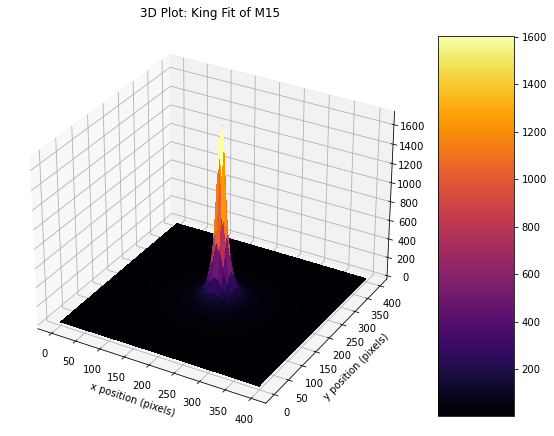

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')

# Make data.
X = np.arange(0, 400, 1)
Y = np.arange(0, 400, 1)
XX, YY = np.meshgrid(X, Y)

# Plot the surface.
surf = ax.plot_surface(XX, YY, Kingfit.reshape(400,400), cmap='inferno',
                       linewidth=0, antialiased=False)

# # Customize the z axis.
ax.set_zlim(0, 1700)

# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# # Add a color bar which maps values to colors.
plt.colorbar(surf, aspect=5)
plt.xlabel('x position (pixels)')
plt.ylabel('y position (pixels)')
plt.title('3D Plot: King Fit of M15')
plt.savefig('3D Plot: King Fit of M15')
plt.show()

In [12]:
#The parameters of the King fit which give an accurate centre pixel coordinate
print(popt)

[2.11926492e+02 1.97100517e+02 9.44414806e+00 5.75369956e+08
 2.00000000e+03]
